In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import deque
import random
import torch
import copy
import gym
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt


class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fcQ1 = torch.nn.Linear(4, 256)
        self.fcQ2 = torch.nn.Linear(256, 1)
      
        
    def forward(self, x,u):
        x = torch.cat([x, u], dim=1)
        x = self.fcQ1(x)
        x = torch.nn.functional.relu(x)
        x = self.fcQ2(x)

 
        return x

    
    
class PolicyNetwork(torch.nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fcA1 = torch.nn.Linear(3, 256)
        self.fcA2 = torch.nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.fcA1(x)
        x = torch.nn.functional.relu(x)
        x = self.fcA2(x)
        x = max_action*torch.tanh(x)
        return x
    



def train(pi,pi_target,Q,Q_target,pi_optimizer,Q_optimizer,history):
    critic_loss = 0
    actor_loss = 0
    states = []
    actions = []
    next_states = []
    rewards = []
    done_masks = []

    for state, action, next_state, reward, done in random.sample(history, mini_batch_size):
        states.append(state)
        actions.append([action])
        rewards.append([reward])
        next_states.append(next_state)
        done_mask = 0.0 if done else 1.0 
        done_masks.append([done_mask])
      

    states = torch.tensor(states, dtype=torch.float)
    actions = torch.tensor(actions, dtype=torch.float)
    rewards = torch.tensor(rewards, dtype=torch.float)
    next_states = torch.tensor(next_states, dtype=torch.float)
    done_masks = torch.tensor(done_masks, dtype=torch.float)

    
    targets = rewards + discount * Q_target(next_states, pi_target(next_states)) * done_masks
        
    critic_loss = torch.nn.functional.smooth_l1_loss(Q(states, actions), targets.detach())
    actor_loss = - Q(states, pi(states)).mean()

    Q_optimizer.zero_grad()
    critic_loss.backward()
    Q_optimizer.step()
       
    pi_optimizer.zero_grad()
    actor_loss.backward()
    pi_optimizer.step()    

Train

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
  

discount = 0.99  # discount factor gamma
mini_batch_size = 32
replay_buffer_size = 50000
scores = []
no_of_episodes = 10000
history = deque(maxlen=replay_buffer_size)  # replay buffer
learning_rate_actor = 0.0005
learning_rate_critic = 0.0005
soft_rate = 0.05
max_action = 2
expl_noise = 0.01

# gym environment
env = gym.make("Pendulum-v0")

    

# network and optimizer
pi = PolicyNetwork()
pi_target = copy.deepcopy(pi)
pi_optimizer = torch.optim.Adam(pi.parameters(), lr=learning_rate_actor)


Q = QNetwork()
Q_target = copy.deepcopy(Q)
Q_optimizer = torch.optim.Adam(Q.parameters(), lr=learning_rate_critic)
    
    
    
score = 0.0  
scores = []
print_interval = 20
# training
for episode in range(no_of_episodes):
    # sum of accumulated rewards
    
    # get initial observation
    x = env.reset()
    done = False


    # loop until an episode ends
    while not done:
        
        u = pi(torch.from_numpy(x).float()) 
        u = u.item()
        u = u + np.random.normal(0, max_action * expl_noise, size=1)
        u  = u.clip(-max_action, max_action)

     
        
           
        x_next, r, done, _ = env.step(u)

        # collect reward
        score = score + r
        scores.append(r)

        # collect a transition
        history.append([x, u, x_next, r, done])
        
        if len(history)>2000:
            for _ in range(10):
                train(pi,pi_target,Q,Q_target,pi_optimizer,Q_optimizer,history)
                # Soft update
                for target_param, param in zip(Q_target.parameters(), Q.parameters()):
                    target_param.data.copy_(param.data * soft_rate + target_param.data * (1 - soft_rate))
                for target_param, param in zip(pi_target.parameters(), pi.parameters()):
                    target_param.data.copy_(param.data * soft_rate + target_param.data * (1 - soft_rate))            
        # pass observation to the next step
        x = x_next
    
    if episode%print_interval==0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f}".format(episode, score/print_interval))
        scores.append(score)
        score = 0.0 





# of episode :0, avg score : -79.5


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

Plot learning curve

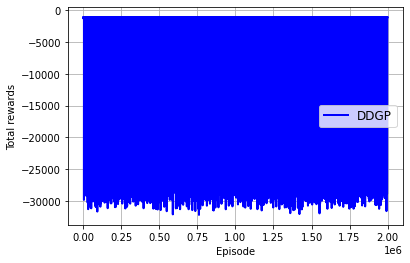

In [ ]:
plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'DDGP')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
#plt.xlim(0, no_of_episodes)
#plt.ylim(0, 20000)
#plt.legend(['Double DQN', 'Dueling DQN', 'D3QN'], loc=4)
plt.grid(True)



In [ ]:
# Test
from time import sleep

for n_epi in range(2):
    s = env.reset()
    done = False
        
    while not done:
        a= pi(torch.from_numpy(s).float()) 
        a = a.item()
        s_prime, r, done, info = env.step([a])
        env.render()
        sleep(0.01)
        score +=r
        s = s_prime
                
        
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

env.close()